In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import astropy.io.ascii as aia
import bz2
import glob
import pickle
import pystan
import re
import scipy.optimize as so
import scipy.stats as ss
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Mini}{M_\mathrm{ini}}
\newcommand{\MSun}{M_\odot}
\newcommand{\Myr}{\mathrm{Myr}}
$$

Settings for publication quality figures.

In [2]:
colwidth = 245.26653/72 # inches

pubplotsize = (colwidth,colwidth)

pubrc = {
    'text.usetex': True,
    'font.family': 'serif',
    'figure.figsize': pubplotsize
}

# Re-Analysis of Schneider+ IMF Data

## Setup, Model

[Schneider, et al. (2018)](https://dx.doi.org/10.1126/science.aan0106) report on an analysis of the stellar parameters of massive stars in 30 Dor that suggests that the high-mass end of the IMF contains more stars than suggested by a Salpeter IMF (i.e. the power-law is shallower than $\diff{N}{M} \propto M^{-2.35}$, more like $\diff{N}{M} \propto M^{-1.9}$).  However, their analysis rests on summing the posteriors of stellar parameters for their sample of observed stars!  Therefore, the distributions they obtain for stellar ages and stellar masses represent the *convolution* of the true distributions for these quantities with observational errors (see, e.g. [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract)); convolving a (broad---See Fig 1 from Schneider, et al. (2018)) observational uncertainty with a steep power law tends to shallow the power law at the high mass end, suggesting that their differences with Salpeter may (at least partly) be a result of their flawed statistical approach.

Schneider, et al. (2018) should be *commended* for providing the data from their stellar parameter fits.  I downloaded the data.  Then I realised they should also be *reprimanded* for not using a truly machine-readable format!  But no matter; by reading the header and manually putting in column names, I can parse it:

In [3]:
stellar_parameters_all = genfromtxt('aan0106_Data_S1.txt', delimiter='\t', comments='#', usecols=(6,7,8,10,11,12,23,24,25,31,32,33), names=('Teff', 'dTeffp', 'dTeffm', 'logg', 'dloggp', 'dloggm', 'Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem'))

We will work with two different data sets in this work.  The first, which we call ``safe`` is the set that has no ``NaN``s in any of the columns we are reading; the second, which we will call ``expanded`` has no ``NaN``s in the mass or age columns.  This latter set corresponds to the Schneider+ data, but we are nervous about using stars for which no Teff or logg can be determined, so we will run with both sets.

In [7]:
safe_sel = np.ones(stellar_parameters_all['Mini'].shape[0], dtype=np.bool)
expanded_sel = np.ones(stellar_parameters_all['Mini'].shape[0], dtype=np.bool)

for n in stellar_parameters_all.dtype.names:
    safe_sel = safe_sel & (~np.isnan(stellar_parameters_all[n]))

for n in ['Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem']:
    expanded_sel = expanded_sel & (~np.isnan(stellar_parameters_all[n]))

stellar_parameters_safe = stellar_parameters_all[safe_sel]
stellar_parameters_expanded = stellar_parameters_all[expanded_sel]

Here is the ``safe`` data and the ``expanded`` data:

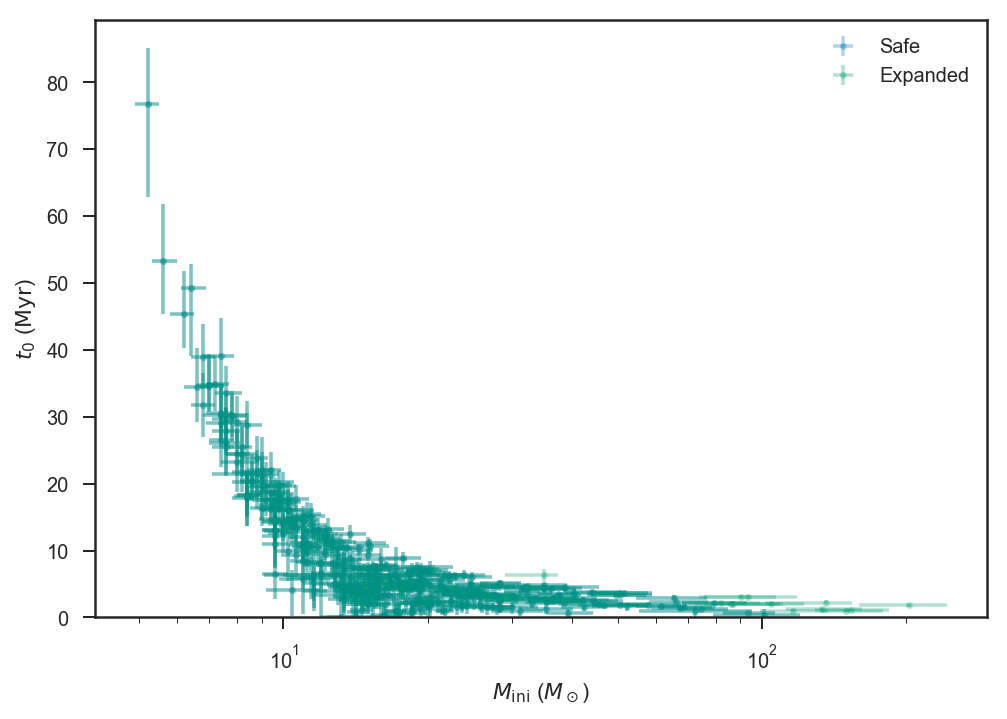

In [10]:
errorbar(stellar_parameters_safe['Mini'], stellar_parameters_safe['age'], yerr=(stellar_parameters_safe['dagem'], stellar_parameters_safe['dagep']), xerr=(stellar_parameters_safe['dMinim'], stellar_parameters_safe['dMinip']), fmt='.', alpha=0.3, label='Safe')
errorbar(stellar_parameters_expanded['Mini'], stellar_parameters_expanded['age'], yerr=(stellar_parameters_expanded['dagem'], stellar_parameters_expanded['dagep']), xerr=(stellar_parameters_expanded['dMinim'], stellar_parameters_expanded['dMinip']), fmt='.', alpha=0.3, label='Expanded')
axis(ymin=0)
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
legend(loc='best')
savefig('age-mass-all.pdf')

In [11]:
len(stellar_parameters_all), len(stellar_parameters_safe), len(stellar_parameters_expanded)

(572, 387, 400)

And restricting to $\Mini \geq 15 \, \MSun$:

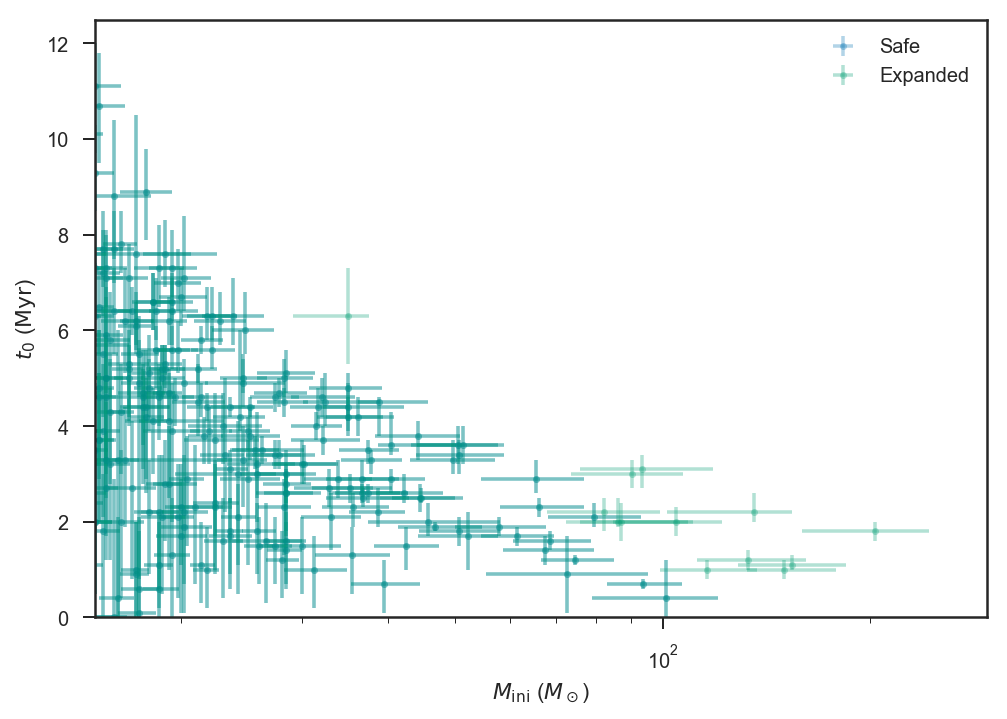

In [12]:
errorbar(stellar_parameters_safe['Mini'], stellar_parameters_safe['age'], yerr=(stellar_parameters_safe['dagem'], stellar_parameters_safe['dagep']), xerr=(stellar_parameters_safe['dMinim'], stellar_parameters_safe['dMinip']), fmt='.', alpha=0.3, label='Safe')
errorbar(stellar_parameters_expanded['Mini'], stellar_parameters_expanded['age'], yerr=(stellar_parameters_expanded['dagem'], stellar_parameters_expanded['dagep']), xerr=(stellar_parameters_expanded['dMinim'], stellar_parameters_expanded['dMinip']), fmt='.', alpha=0.3, label='Expanded')
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=15, ymin=0, ymax=12.5)
legend(loc='best')
savefig('age-mass-zoom.pdf')

I grabbed the non-rotating evolutionary models from [Brott, et al. (2011)](https://dx.doi.org/10.1051/0004-6361/201016113) from [VizieR](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/530/A115#sRM2.1).  I also grabbed `models.dat`, which gives the masses for the models.

Since 30 Dor has a metallicity around half the solar value, I think it is probably best to use the LMC lifetimes.

In [13]:
masses = []
lifetimes = []
for f in glob.glob('evol/f*.dat'):
    m = float(int(re.match('.*f([0-9]+)-.*', f).group(1)))
    lt = np.max(genfromtxt(f, delimiter='|', usecols=(0,)))
    masses.append(m)
    lifetimes.append(lt)
masses = array(masses)
lifetimes = array(lifetimes)
inds = argsort(masses)
masses = masses[inds]
lifetimes = lifetimes[inds]

The plot below is restricted to $M \geq 15 \, \MSun$.

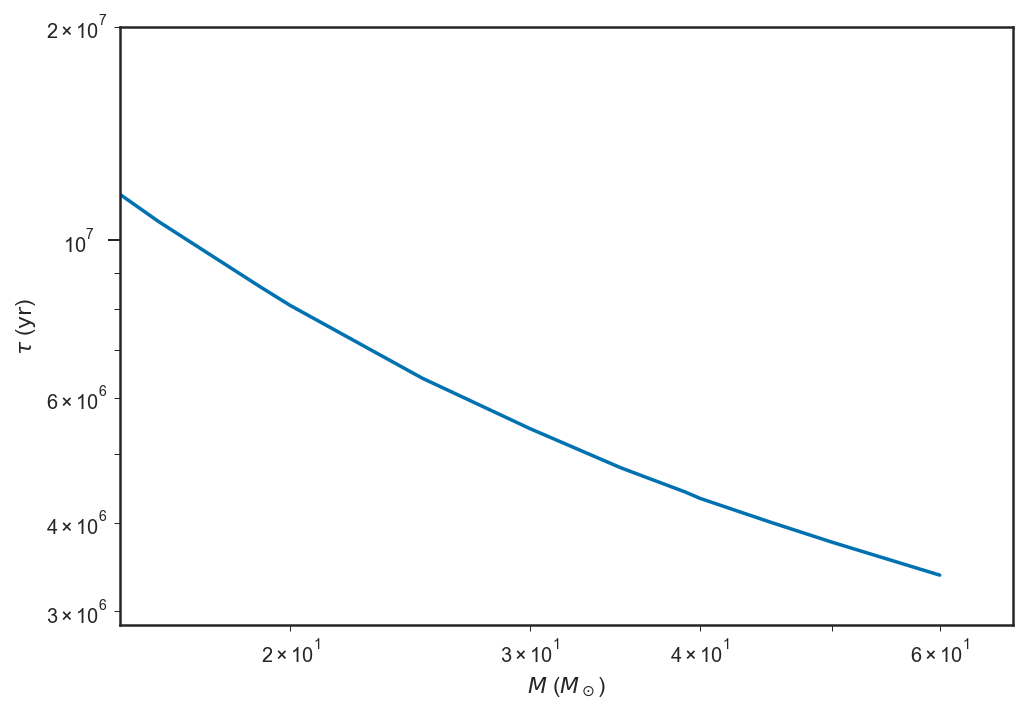

In [14]:
plot(masses, lifetimes)
xscale('log')
yscale('log')
axis(xmin=15, ymax=2e7)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

A fit in logspace to a third-order polynomial:

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


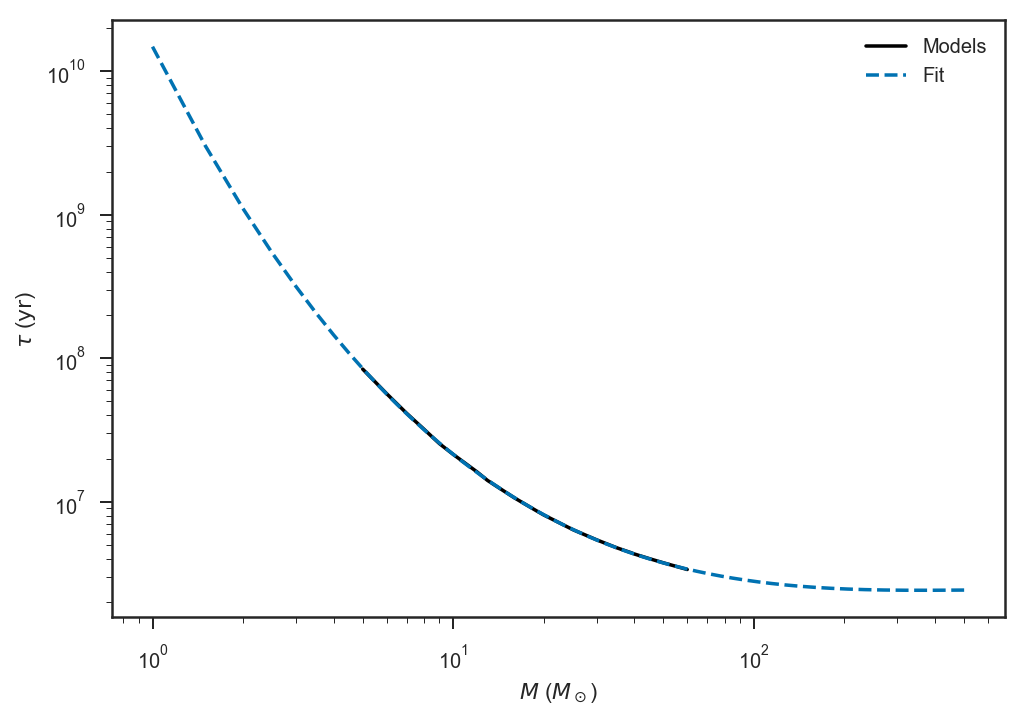

In [16]:
nmasses = masses.shape[0]
M = column_stack((ones(nmasses), log(masses), log(masses)**2, log(masses)**3))
c_lifetime = np.linalg.lstsq(M, log(lifetimes/1e6))[0]
plot(masses, lifetimes, '-k', label='Models')

fit_masses = linspace(1, 500, 1000)
Mfit = column_stack((ones(1000), log(fit_masses), log(fit_masses)**2, log(fit_masses)**3))

plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T))*1e6, '--', label='Fit')
xscale('log')
yscale('log')

legend(loc='best')

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

savefig('lifetime-fit.pdf')

Fabian pointed out that our lifetimes are too short, as the He burning phase will give an extra 10% (almost independent of mass) to the time that the star is visible.

In [17]:
def lifetime(M, cs):
    return 1.1*np.exp(np.dot([1.0, log(M), log(M)**2, log(M)**3], cs))

Fabian was nice enough to give us his lifetime fit, which is reproduced below.  He pointed out that we did not include an extra 10% in age to account for He burning (we used the end of the main sequence to define the "lifetime").

In [18]:
def lifetime_fabian(M):
    x=log10(M)
    logtau = (((0.0704678215679923*x - 0.703265121302702)*x + 2.83657884428275)*x - 5.55038963196851)*x + 4.67513260277302
    return 1.1*pow(10.0, logtau)

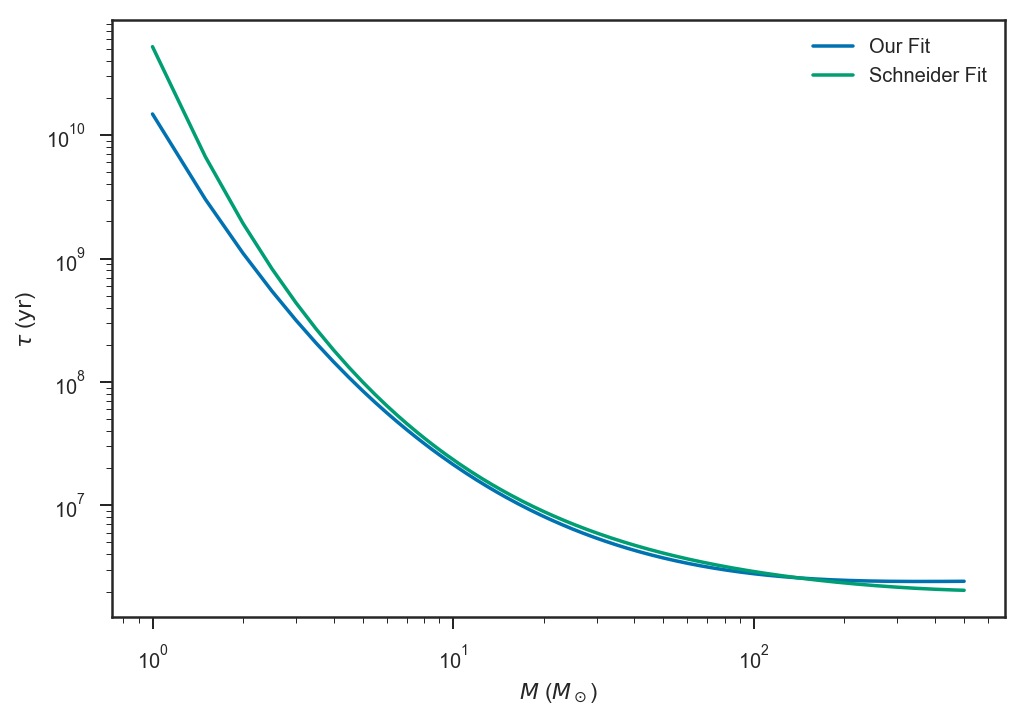

In [19]:
plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T))*1e6, label='Our Fit')
plot(fit_masses, [1e6*lifetime_fabian(m) for m in fit_masses], label='Schneider Fit')
yscale('log')
xscale('log')
legend(loc='best')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

Let's compare against the observed (expanded) sample.  At the high-mass end, the Schneider lifetime is a bit shorter, and therefore there will be more "dead" massive stars imputed when using it and the power-law exponent should turn up shallower.

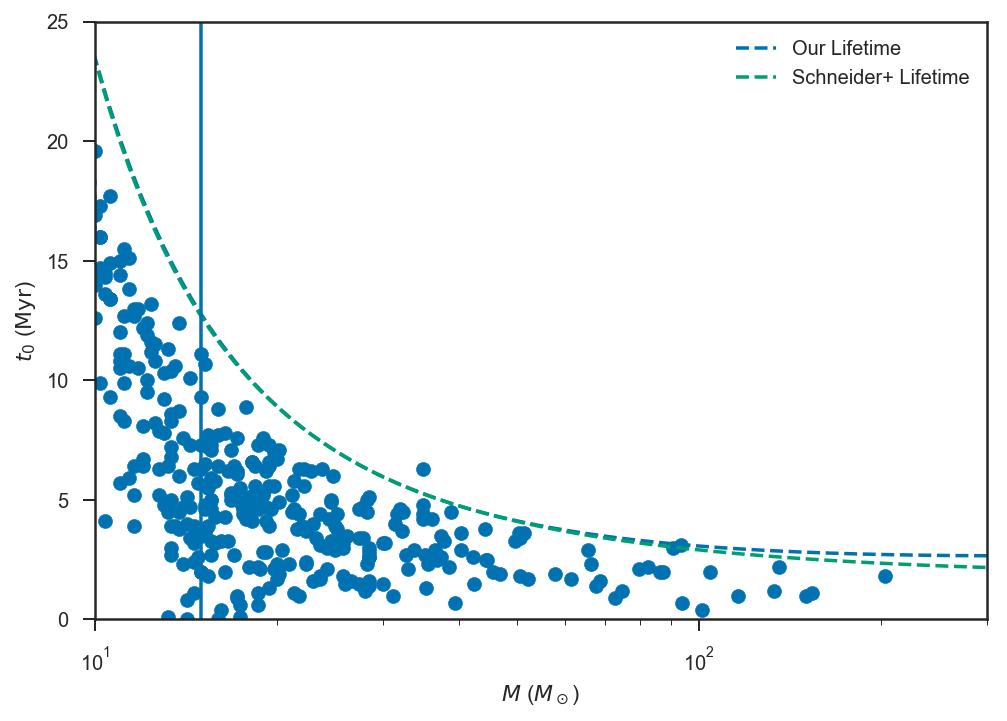

In [21]:
plot(fit_masses, [lifetime(m, c_lifetime) for m in fit_masses], '--', label='Our Lifetime')
plot(fit_masses, [lifetime_fabian(m) for m in fit_masses], '--', label='Schneider+ Lifetime')
legend(loc='best')
xscale('log')
scatter(stellar_parameters_expanded['Mini'], stellar_parameters_expanded['age'])

axis(xmin=10, xmax=300, ymax=25, ymin=0)

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')

axvline(15) # Completeness line.

savefig('lifetime-data.pdf')

The model is implemented in `IMF.stan`.  Here are a few notes about how the model works.  First, we use a population model that is 
$$
\diff{N}{M \dd t} = \frac{\Lambda \left( \alpha - 1 \right)}{M_\mathrm{cut}} \left( \frac{M}{M_\mathrm{cut}} \right)^{-\alpha} \frac{N\left( t \mid \mu_t, \sigma_t \right)}{\Phi\left( t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
In words: a power-law mass function and a Gaussian SFR, with expected number of stars formed with ages between $0$ and $t_\mathrm{max}$ of order $\Lambda$ (not extactly $\Lambda$ because some stars will have *true* masses below $M_\mathrm{cut}$).  Parameters are $\Lambda$, $\alpha$, $\mu_t$, $\sigma_t$.  Note that here $M_\mathrm{cut}$ is the cut on the *observed* mass (so the population can extend below $M_\mathrm{cut}$).

We assume that the observational likelihood function is a product of normal distributions for log(mass) and age (independently), with location parameters at the quoted (MAP?) value, and scale parameters that are half the quoted 68% width.  This is lighter-tailed than some of the likelihoods presented in Schneider, et al. (2018), and is also symmetric unlike those distributions, but it is easy to implement.  In simpler models, we have used heavier-tailed distributions and found that the tails did not really influence the fit at all.  

To implement the selection effects, we use direct integration.  We can analytically integrate over the *observable* region in parameter space in age, since the SFR is just a Gaussian (we get a difference of Gaussian CDFs).  Integrating over $M$ is not possible with simple functions, but we can use Stan's ODE computation to solve 
$$
\diff{f_\mathrm{obs}}{M} = \frac{\alpha - 1}{M_\mathrm{cut}} \left( \frac{M}{M_\mathrm{cut}} \right)^{-\alpha} \frac{\Phi\left( t_+(M) \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}{\Phi\left(t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)} P_\mathrm{det}\left( M \right)
$$
where $t_+(M)$ is the maximum lifetime for *observable* systems at mass $M$; $P_\mathrm{det}\left( M \right)$ is the probability that a system with true mass $M$ will be detected: 
$$
P_\mathrm{det}(M) \equiv \int_{M_\mathrm{cut}}^\infty \dd M_\mathrm{obs} \, p\left( M_\mathrm{obs} \mid M \right),
$$
which can be written in terms of the CDF for the normal distribution governing $\log M_\mathrm{obs}$; and 
$f_\mathrm{obs}(\infty) \Lambda$ is the number of stars that are *observable*, using the initial condition that $f_\mathrm{obs}\left( M_\mathrm{min} \right) = 0$ (where $M_\mathrm{min}$ is some lower mass---the integrand is singular at $M = 0$---that is sufficiently small that $P_\mathrm{det}\left( M_\mathrm{min} \right) \simeq 0$).  The normalising term in the inhomogeneous Poisson distribution is then 
$$
\exp\left[ -\Lambda f_\mathrm{obs}(\infty) \right],
$$
or the exponential of the expected number of *observed* systems.

Note that for sufficiently large uncertainties or steep slopes it can happen that $f_\mathrm{obs}(\infty) > 1$.

To construct the likelihood described above, we produce fictituous $M_\mathrm{obs}$ and uncertainties so the likelihood is normal for $\log M$ and $t$ with the quoted 68% interval.

In [22]:
mupper = stellar_parameters_all['Mini'] + stellar_parameters_all['dMinip']
mlower = stellar_parameters_all['Mini'] - stellar_parameters_all['dMinim']

logm_obs = log(stellar_parameters_all['Mini'])
sigma_logm_obs = 0.5*(log(mupper) - log(mlower))

tupper = stellar_parameters_all['age'] + stellar_parameters_all['dagep']
tlower = stellar_parameters_all['age'] - stellar_parameters_all['dagem']

t_obs = stellar_parameters_all['age']
sigma_t_obs = 0.5*(tupper - tlower)

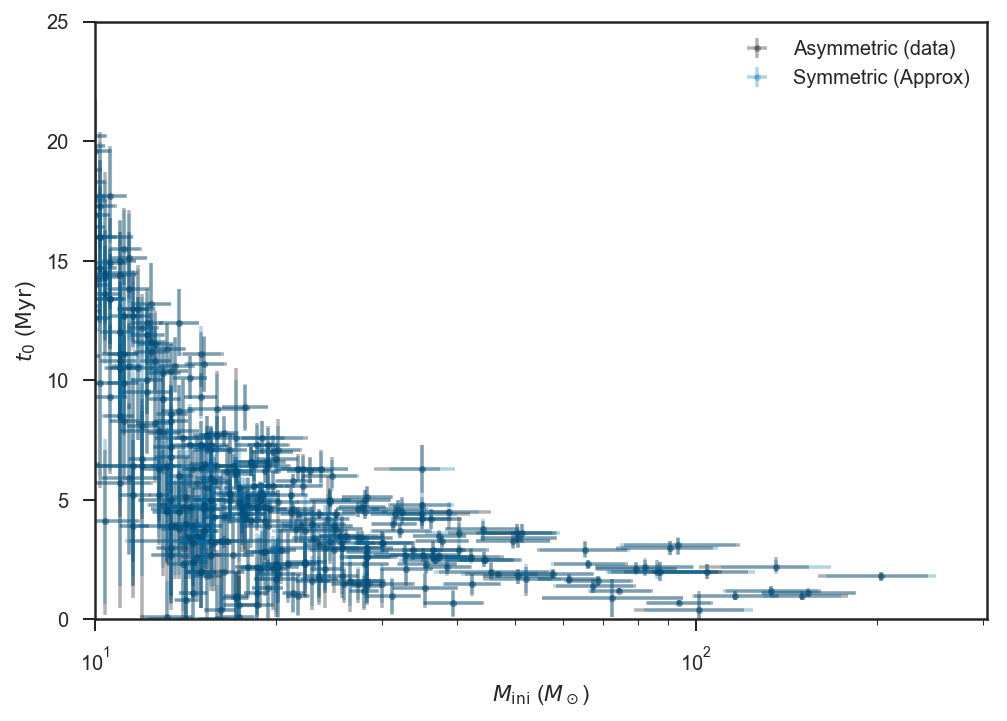

In [24]:
errorbar(stellar_parameters_all['Mini'], stellar_parameters_all['age'], yerr=(stellar_parameters_all['dagem'], stellar_parameters_all['dagep']), xerr=(stellar_parameters_all['dMinim'], stellar_parameters_all['dMinip']), fmt='.', color='k', alpha=0.3, label="Asymmetric (data)")
errorbar(exp(logm_obs), t_obs, yerr=sigma_t_obs, xerr=(exp(logm_obs)-exp(logm_obs - sigma_logm_obs), -exp(logm_obs) + exp(logm_obs+sigma_logm_obs)), fmt='.', color=sns.color_palette()[0], alpha=0.3, label="Symmetric (Approx)")
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=10, ymin=0, ymax=25)
legend(loc='best')

We need to estimate the typical uncertainty of the observations near $M_\mathrm{min}$ so that we can implement the selection effect integral above.  Here is a plot of the uncertainty in $\log M$ versus $M$:

Median (i.e. typical) sigma_logm is 0.08


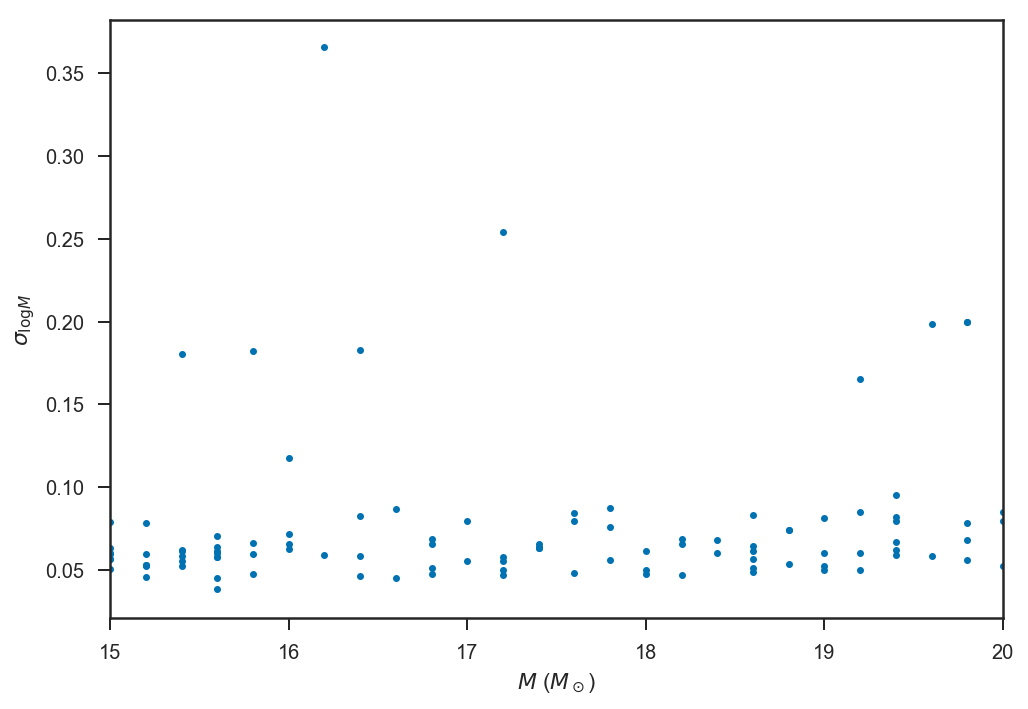

In [27]:
plot(stellar_parameters_all['Mini'], sigma_logm_obs, '.')
axis(xmin=15, xmax=20)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\sigma_{\log M}$')

sigma_logm_typ = median(sigma_logm_obs[stellar_parameters_all['Mini']>15])

print('Median (i.e. typical) sigma_logm is {:.2f}'.format(sigma_logm_typ))

We use ``sigma_logm_typ`` to implement selection effects in the integral over the un-observed systems.

## Fitting

First, some utility functions:

In [28]:
def dump_fit(model, fit, file):
    chain = fit.extract(permuted=True)
    
    with bz2.BZ2File(file, 'w') as out:
        pickle.dump(model, out)
        pickle.dump(fit, out)
        pickle.dump(chain, out)
        
def load_fit(file):
    with bz2.BZ2File(file, 'r') as inp:
        model = pickle.load(inp)
        fit = pickle.load(inp)
        chain = pickle.load(inp)
        
    return (model, fit, chain)

The model we use is defined in `IMF.stan`.

In [29]:
model = pystan.StanModel(file='IMF.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17a34d3a6be4b3a11a681646dbf17366 NOW.


We only consider systems that have formed in the last $25 \, \Myr$, and select systems with MAP (i.e. "observed") masses above $15 \, \MSun$ by default; we will also try $20 \, \MSun$ to check whether lower mass limit influences the result (Schneider+ claim that the survey is complete around $15 \, \MSun$).

In [33]:
MCut_std = 15.0
MCut_high = 20.0
tMax = 25.0

We use an $M_\mathrm{min}$ so that $P_\mathrm{det}\left( M_\mathrm{min} \right) = 10^{-4}$ in our standard analysis; it will be even smaller in the high-mass cut:

In [34]:
MMin = exp(so.brentq(lambda lmm: ss.norm(loc=log(MCut_std), scale=sigma_logm_typ).cdf(lmm) - 0.0001, log(1), log(15)))
print("MMin = ", MMin)

MMin =  11.015039685920566


Here is our "standard" analysis, which reproduces the Schneider+ analysis, but using the correct hierarchical modelling.

In [49]:
sel_std = (stellar_parameters_all['Mini'] > MCut_std) & expanded_sel
data_std = {
    'nltc': len(c_lifetime),
    'ltc': c_lifetime,
    'schneider_flag': 1,
    
    'MMin': MMin,
    'MCut': MCut_std,
    'tmax': tMax,
    'sigma_logM_typ': sigma_logm_typ,
    
    'nobs': count_nonzero(sel_std),
    'log_Mobs': logm_obs[sel_std],
    'sigma_logM': sigma_logm_obs[sel_std],
    'ageobs': t_obs[sel_std],
    'sigma_age': sigma_t_obs[sel_std],
}

In [50]:
fit_std = model.sampling(data=data_std, iter=2000, thin=1)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [51]:
fit_std

Inference for Stan model: anon_model_17a34d3a6be4b3a11a681646dbf17366.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   323.79     0.5  31.35 269.08 301.67 321.38 342.96  393.3   4000    1.0
alpha                 2.05  2.1e-3   0.13   1.81   1.96   2.05   2.14   2.31   4000    1.0
mu_t                  4.26  3.3e-3   0.21   3.86   4.12   4.26    4.4   4.67   4000    1.0
sigma_t               2.19  3.0e-3   0.19   1.86   2.05   2.18   2.31    2.6   4000    1.0
Mtrue[0]             63.22    0.16  10.28  45.22  56.04  62.45  69.51  85.63   4000    1.0
Mtrue[1]             18.97    0.02   0.98  17.07  18.31  18.94  19.63  20.92   4000    1.0
Mtrue[2]             26.04    0.05   3.12  20.47  23.92   25.8  27.98  32.81   4000    1.0
Mtrue[3]             92.53    0.19  11.95  71.39  84.01  91.82 100.08 117.66   4000

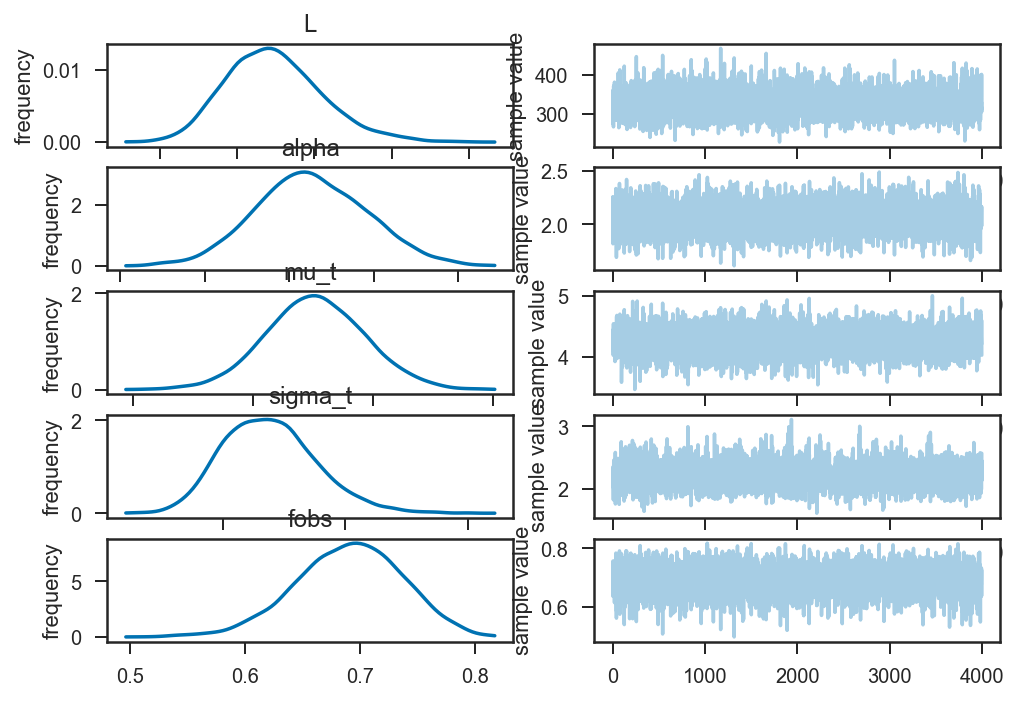

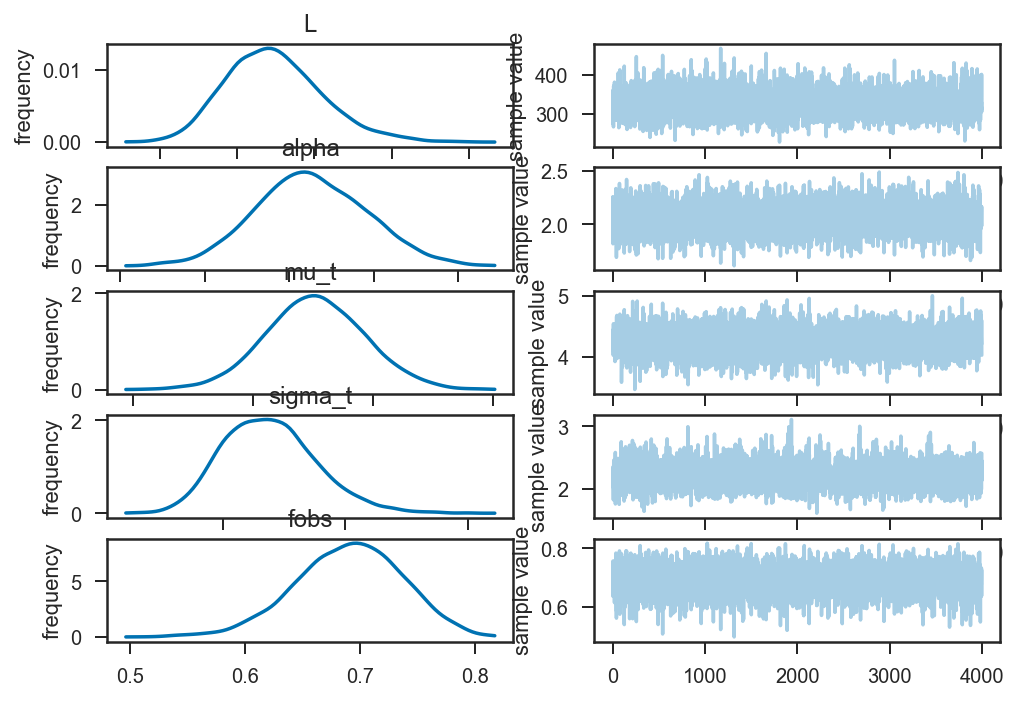

In [52]:
fit_std.plot(["L", "alpha", "mu_t", "sigma_t", 'fobs'])

In [53]:
chain_std = fit_std.extract(permuted=True)

In [54]:
dump_fit(model, fit_std, 'std.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [55]:
_, fit_std, chain_std = load_fit('std.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now let's do a run that is identical to the above, but uses our fit to the lifetimes.

In [56]:
data_our_lt = data_std.copy()
data_our_lt['schneider_flag'] = 0

In [57]:
fit_our_lt = model.sampling(data=data_our_lt, iter=2000, thin=1)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [58]:
fit_our_lt

Inference for Stan model: anon_model_17a34d3a6be4b3a11a681646dbf17366.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   310.33    0.45  28.53 259.27 290.34 308.31 328.91 370.35   4000    1.0
alpha                 2.13  2.1e-3   0.13   1.87   2.04   2.13   2.21   2.39   4000    1.0
mu_t                  4.23  3.4e-3   0.21   3.83   4.09   4.23   4.37   4.67   4000    1.0
sigma_t               2.21  3.2e-3    0.2   1.87   2.07   2.19   2.33   2.68   4000    1.0
Mtrue[0]             63.95    0.17  10.66  45.97  56.37  63.09   70.6  87.18   4000    1.0
Mtrue[1]             18.97    0.02   0.98  17.13  18.28  18.94  19.61  20.92   4000    1.0
Mtrue[2]             25.98    0.05   3.24  20.16  23.73  25.76   28.0  32.97   4000    1.0
Mtrue[3]             92.61    0.18   11.7   72.0  84.22  92.04  99.84 118.33   4000

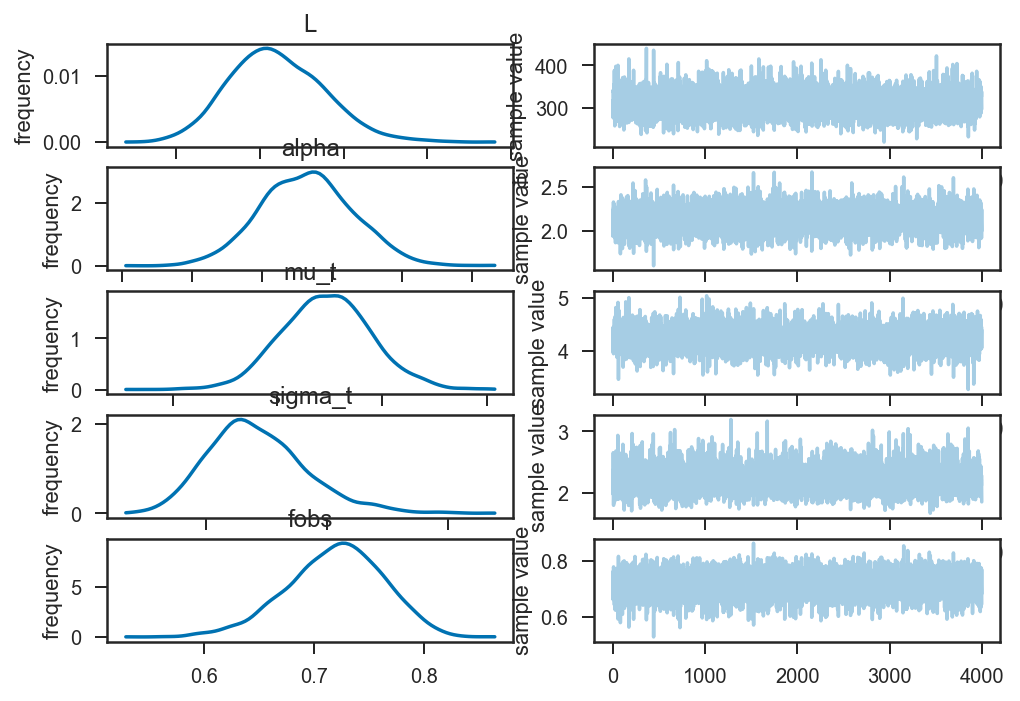

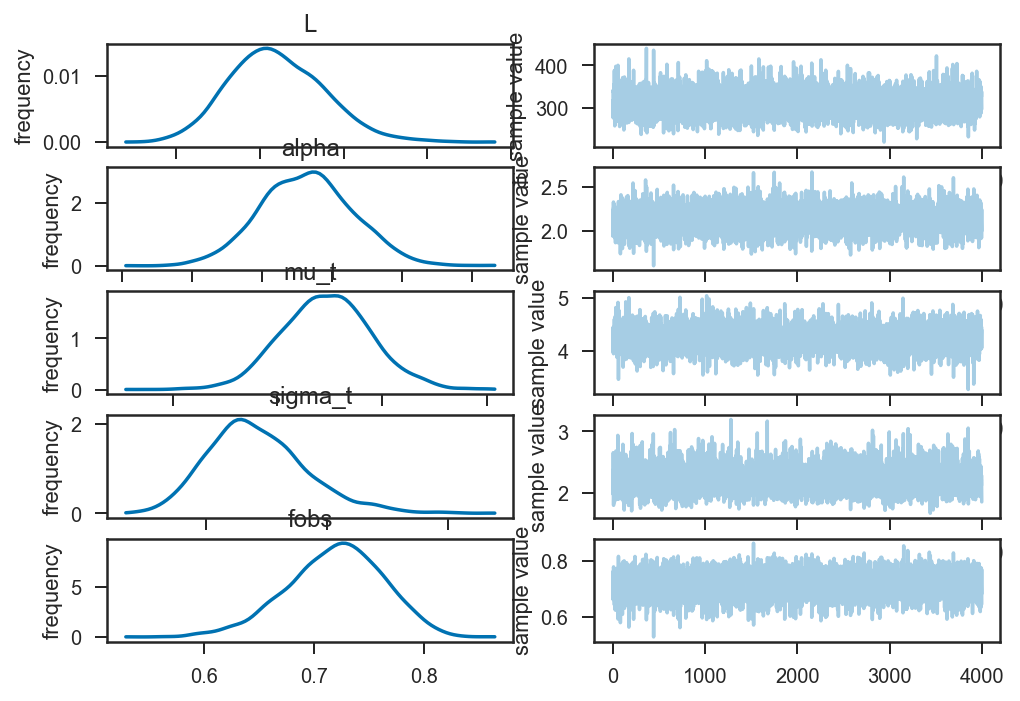

In [59]:
fit_our_lt.plot(["L", "alpha", "mu_t", "sigma_t", 'fobs'])

In [60]:
chain_our_lt = fit_our_lt.extract(permuted=True)

In [61]:
dump_fit(model, fit_our_lt, 'our_lt.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [62]:
_, fit_our_lt, chain_our_lt = load_fit('our_lt.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now we use our lifetimes *and* the $20 \, \MSun$ cutoff:

In [83]:
sel_20 = (stellar_parameters_all['Mini'] > MCut_high) & expanded_sel

data_our_lt_20cut = data_our_lt.copy()
data_our_lt_20cut['MMin'] = MCut_high
data_our_lt_20cut['nobs'] = count_nonzero(sel_20)
data_our_lt_20cut['log_Mobs'] = logm_obs[sel_20]
data_our_lt_20cut['sigma_logM'] = sigma_logm_obs[sel_20]
data_our_lt_20cut['ageobs'] = t_obs[sel_20]
data_our_lt_20cut['sigma_age'] = sigma_t_obs[sel_20]

In [84]:
fit_our_lt_20cut = model.sampling(data=data_our_lt_20cut, iter=2000, thin=1)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [85]:
fit_our_lt_20cut

Inference for Stan model: anon_model_17a34d3a6be4b3a11a681646dbf17366.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   247.65    0.37   23.3  205.3 231.82 246.42  262.7 296.84   4000    1.0
alpha                 2.23  2.6e-3   0.17   1.92   2.11   2.22   2.34   2.57   4000    1.0
mu_t                  3.45  3.3e-3   0.21   3.06   3.31   3.44   3.58   3.89   4000    1.0
sigma_t               1.64  3.1e-3    0.2   1.33   1.51   1.62   1.75    2.1   4000    1.0
Mtrue[0]             63.45    0.17  10.83  45.15  55.68  62.61  70.17  87.31   4000    1.0
Mtrue[1]             26.08    0.05   3.07  20.93  23.85  25.82  27.96   32.9   4000    1.0
Mtrue[2]             92.48    0.18  11.62  72.16  84.22  91.68 100.08 117.04   4000    1.0
Mtrue[3]             21.33    0.02   1.02  20.05  20.53  21.11  21.94  23.81   4000

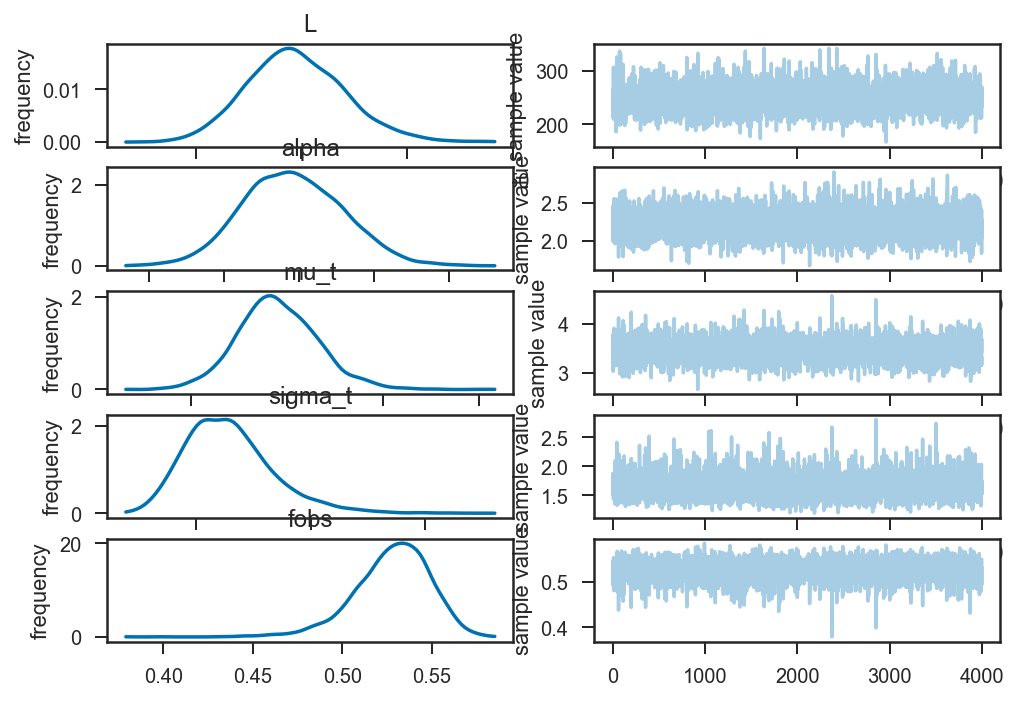

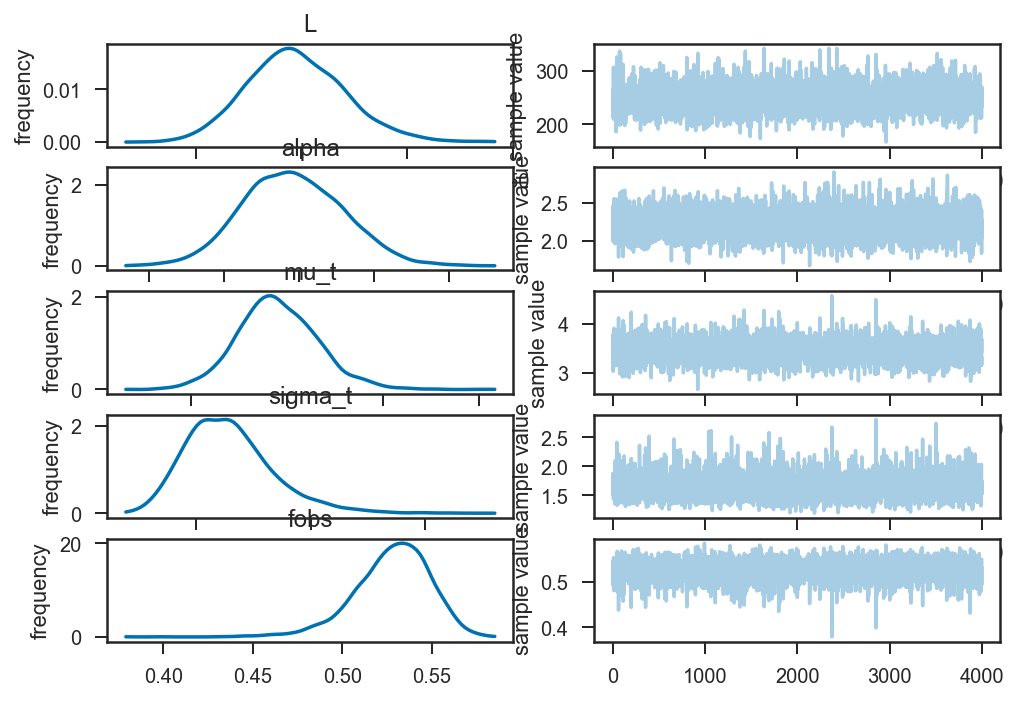

In [86]:
fit_our_lt_20cut.plot(["L", "alpha", "mu_t", "sigma_t", 'fobs'])

In [87]:
chain_our_lt_20cut = fit_our_lt_20cut.extract(permuted=True)

In [88]:
dump_fit(model, fit_our_lt_20cut, 'our_lt_20cut.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [89]:
_, fit_our_lt_20cut, chain_our_lt_20cut = load_fit('our_lt_20cut.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


And, finally, we leave out the stars without logg and Teff.

In [90]:
sel_20safe = (stellar_parameters_all['Mini'] > MCut_high) & safe_sel

data_our_lt_20cut_safe = data_our_lt_20cut.copy()
data_our_lt_20cut_safe['nobs'] = count_nonzero(sel_20safe)
data_our_lt_20cut_safe['log_Mobs'] = logm_obs[sel_20safe]
data_our_lt_20cut_safe['sigma_logM'] = sigma_logm_obs[sel_20safe]
data_our_lt_20cut_safe['ageobs'] = t_obs[sel_20safe]
data_our_lt_20cut_safe['sigma_age'] = sigma_t_obs[sel_20safe]

In [91]:
fit_our_lt_20cut_safe = model.sampling(data=data_our_lt_20cut_safe, iter=2000, thin=1)

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [92]:
fit_our_lt_20cut_safe

Inference for Stan model: anon_model_17a34d3a6be4b3a11a681646dbf17366.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                   231.08    0.36  23.02 188.49 214.97 230.39 246.32 277.26   4000    1.0
alpha                 2.68  3.4e-3   0.22   2.27   2.53   2.68   2.83   3.13   4000    1.0
mu_t                  3.44  3.1e-3    0.2   3.05   3.32   3.44   3.57   3.83   4000    1.0
sigma_t               1.57  3.0e-3   0.19   1.27   1.44   1.56   1.68   1.99   4000    1.0
Mtrue[0]             62.63    0.16  10.42  44.44  55.26  61.97  69.29  85.25   4000    1.0
Mtrue[1]             25.93    0.05   3.04  20.73  23.75  25.66  27.79  32.58   4000    1.0
Mtrue[2]              91.9    0.18  11.57  71.14  83.79  91.24  99.24 116.54   4000    1.0
Mtrue[3]             21.27    0.02   1.03  20.04  20.47   21.0  21.84  23.87   4000

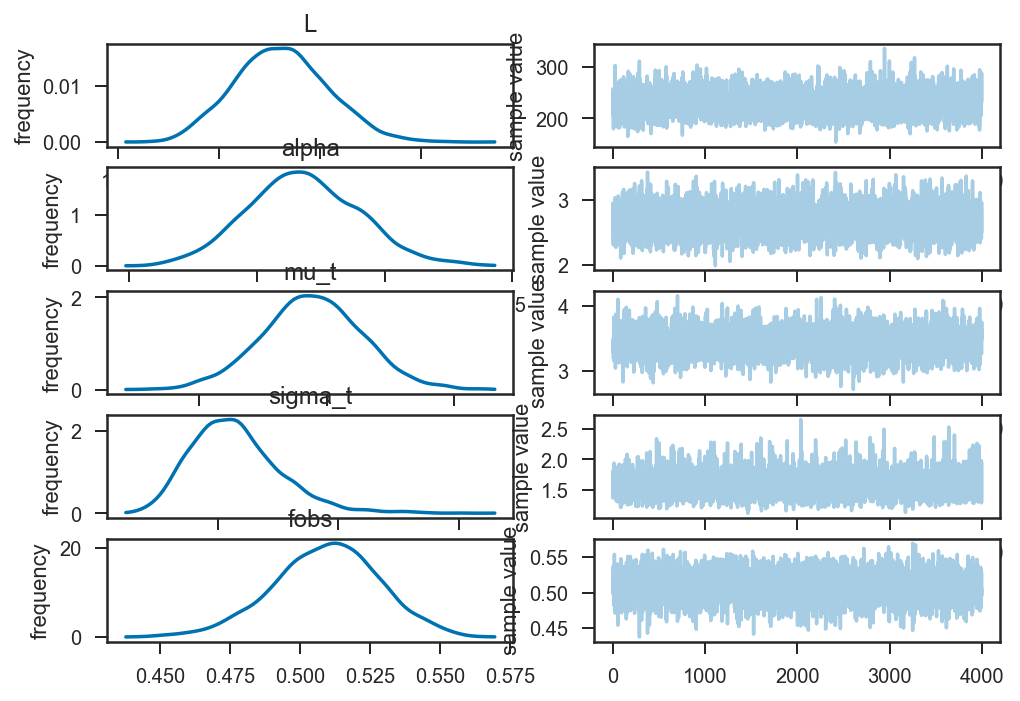

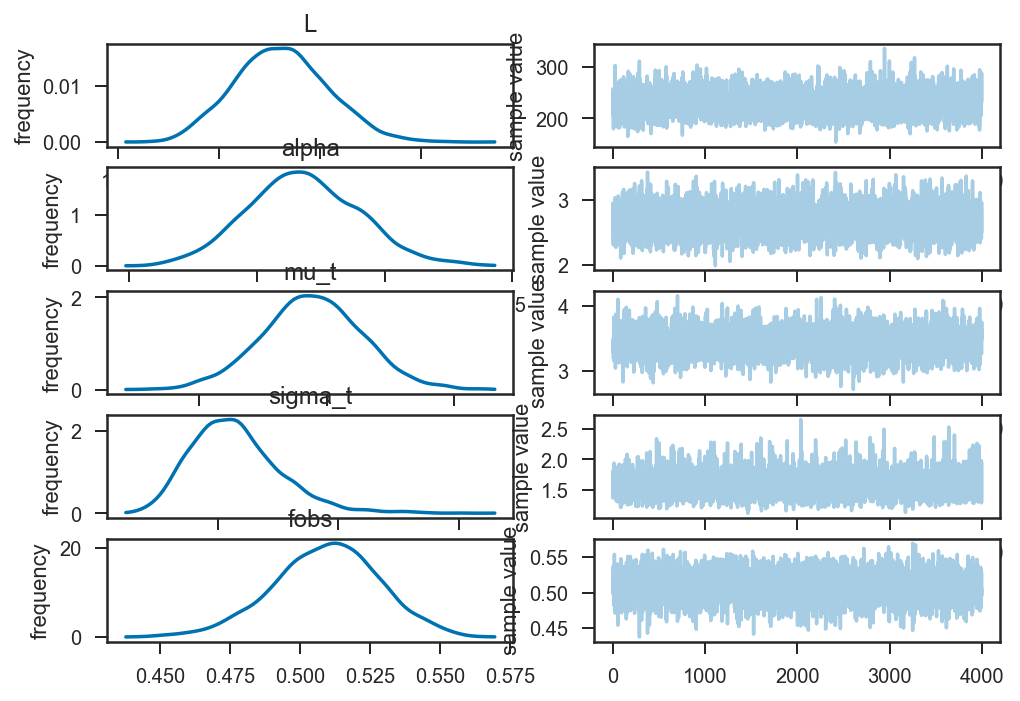

In [93]:
fit_our_lt_20cut_safe.plot(["L", "alpha", "mu_t", "sigma_t", 'fobs'])

In [94]:
chain_our_lt_20cut_safe = fit_our_lt_20cut_safe.extract(permuted=True)

In [95]:
dump_fit(model, fit_our_lt_20cut_safe, 'our_lt_20cut_safe.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


In [96]:
_, fit_our_lt_20cut_safe, chain_our_lt_20cut_safe = load_fit('our_lt_20cut_safe.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Analysis

Code to draw synthetic observations from a posterior sample.

In [97]:
def draw_systems(fit, chain):
    d = fit.data
    
    i = randint(chain['L'].shape[0])
    L = chain['L'][i]
    fobs = chain['fobs'][i]
    alpha = chain['alpha'][i]
    mu = chain['mu_t'][i]
    sigma = chain['sigma_t'][i]
    
    # The distribution is normalised to MCut in the code, but masses can actually be M > MMin
    N = random.poisson(L*d['MMin']**(1-alpha)/d['MCut']**(1-alpha))
    ts = mu + sigma*randn(N)
    while any(ts<0) or any(ts>d['tmax']):
        ts[ts<0] = mu + sigma*randn(count_nonzero(ts<0))
        ts[ts>d['tmax']] = mu + sigma*randn(count_nonzero(ts>d['tmax']))
    ms = d['MMin']*(1-random.uniform(size=N))**(1.0/(1.0-alpha))
    
    # Cut down to main sequence objects
    ms, ts = zip(*[(m,t) for m,t in zip(ms,ts) if t < lifetime(m, c_lifetime)])
    
    # Now get observational errors
    ms_out = []
    dms_out = []
    ts_out = []
    dts_out = []
    
    for m,t in zip(ms, ts):
        sigma_logm = random.choice(d['sigma_logM'])
        sigma_t = random.choice(d['sigma_age'])
        
        dms_out.append(sigma_logm)
        dts_out.append(sigma_t)
        
        mo = exp(ss.norm.rvs(loc=log(m), scale=sigma_logm))
        ms_out.append(mo)
        
        to = -1.0
        while to < 0:
            to = ss.norm.rvs(loc=t, scale=sigma_t)
        ts_out.append(to)
        
    ms_out = array(ms_out)
    dms_out = array(dms_out)
    ts_out = array(ts_out)
    dts_out = array(dts_out)

    sel = ms_out > d['MCut']
        
    return ms_out[sel], dms_out[sel], ts_out[sel], dts_out[sel]

Some useful plotting code:

In [98]:
def plot_dNdM(fit, chain, MMax=200.0, down_select=False, *args, **kwargs):
    MMin = fit.data['MCut']
    
    ms = logspace(log10(MMin), log10(MMax), 1000)[newaxis,:]
    
    alphas = chain['alpha'][:,newaxis]
    Ls = chain['L'][:,newaxis]
    
    dNdMs = Ls*(alphas-1)/MMin*(ms/MMin)**(-alphas)
    
    if down_select:
        mu_t = chain['mu_t']
        sigma_t = chain['sigma_t']
        
        sfactors = array([(ss.norm.cdf(lifetime(m, c_lifetime), loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t)-ss.norm.cdf(0, loc=mu_t, scale=sigma_t)) for m in ms[0,:]])
    
        dNdMs = dNdMs * sfactors.T
        
    m = median(dNdMs, axis=0)
    h = percentile(dNdMs, 84.0, axis=0)
    hh = percentile(dNdMs, 97.5, axis=0)
    l = percentile(dNdMs, 16.0, axis=0)
    ll = percentile(dNdMs, 2.5, axis=0)
    
    ms = ms[0,:]
    
    line, = loglog(ms, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ms, h, l, color=c, alpha=0.25)
    fill_between(ms, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$M$ ($M_\odot$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
    
def plot_dNdt(chain, tmax=25.0, down_select=False, *args, **kwargs):
    ts = linspace(0, tmax, 1000)[newaxis,:]
    
    Ls = chain['L'][:,newaxis]
    mu_t = chain['mu_t'][:,newaxis]
    sigma_t = chain['sigma_t'][:,newaxis]
    
    dNdts = Ls*ss.norm.pdf(ts, loc=mu_t, scale=sigma_t)/(ss.norm.cdf(tMax, loc=mu_t, scale=sigma_t) - ss.norm.cdf(0, loc=mu_t, scale=sigma_t))

    if down_select:
        alphas = chain['alpha'][:,newaxis]
        
        mupper = []
        for t in ts[0,:]:
            if t < lifetime(1000.0, c_lifetime):
                mupper.append(np.inf)
            else:
                mupper.append(so.brentq((lambda m: lifetime(m, c_lifetime)-t), 10.0, 1000.0))
        mupper = array(mupper)
        
        sfactors = 1-(mupper/MCut)**(1-alphas)
        
        dNdts = dNdts * sfactors
    
    ts = ts[0,:]
    
    m = median(dNdts, axis=0)
    h = percentile(dNdts, 84.0, axis=0)
    hh = percentile(dNdts, 97.5, axis=0)
    l = percentile(dNdts, 16.0, axis=0)
    ll = percentile(dNdts, 2.5, axis=0)
    
    line, = plot(ts, m, *args, **kwargs)
    c = line.get_color()
    
    fill_between(ts, h, l, color=c, alpha=0.25)
    fill_between(ts, hh, ll, color=c, alpha=0.25)
    
    xlabel(r'$t$ ($\mathrm{Mya}$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')

Some code that can convert a sample of masses and ages into a density:

In [99]:
def empirical_dNdM(ms, mmin=15.0):
    logms = log(ms)
    
    kde = ss.gaussian_kde(logms)
    
    def dNdM(m):
        return ms.shape[0]*(kde(log(m)) + kde(2*log(mmin)-log(m)))/m
    return dNdM
def empirical_dNdt(ts, tmax=25.0):
    kde = ss.gaussian_kde(ts)
    
    def dNdt(t):
        return ts.shape[0]*(kde(t) + kde(-t) + kde(2*tmax-t))
    
    return dNdt

Execute the cell below to re-load the fits.  If you want to be sure that the model code matches, you can change the `_` to `model` to re-load the model as well, but it is probably safer to re-run the cell above where the model is compiled.

In [100]:
_, fit_std, chain_std = load_fit('std.pkl.bz2')
_, fit_our_lt, chain_our_lt = load_fit('our_lt.pkl.bz2')
_, fit_our_lt_20cut, chain_our_lt_20cut = load_fit('our_lt_20cut.pkl.bz2')
_, fit_our_lt_20cut_safe, chain_our_lt_20cut_safe = load_fit('our_lt_20cut_safe.pkl.bz2')

/Users/farr/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


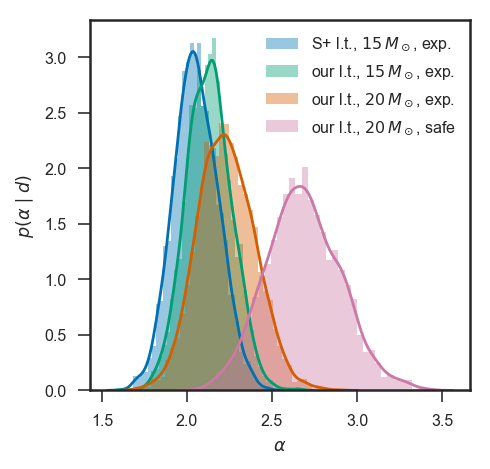

In [103]:
with sns.plotting_context('paper', rc=pubrc):
    sns.distplot(chain_std['alpha'], label=r'S+ l.t., $15 \, M_\odot$, exp.')
    sns.distplot(chain_our_lt['alpha'], label=r'our l.t., $15 \, M_\odot$, exp.')
    sns.distplot(chain_our_lt_20cut['alpha'], label=r'our l.t., $20 \, M_\odot$, exp.')
    sns.distplot(chain_our_lt_20cut_safe['alpha'], label=r'our l.t., $20 \, M_\odot$, safe')
    legend(loc='best')

    xlabel(r'$\alpha$')
    ylabel(r'$p\left( \alpha \mid d \right)$')

    savefig('alpha.pdf')

In [104]:
def one_sigma_range(samples):
    m = median(samples)
    h = percentile(samples, 84)
    l = percentile(samples, 16)
    
    return m, h-m, m-l

In [105]:
print('Alpha ranges:')
print('Schneider+ lifetimes, 15 MSun, expanded data set: {:.2f} + {:.2f} - {:.2f}'.format(*one_sigma_range(chain_std['alpha'])))
print('Our lifetimes, 15 MSun, expanded data set: {:.2f} + {:.2f} - {:.2f}'.format(*one_sigma_range(chain_our_lt['alpha'])))
print('Our lifetimes, 20 MSun, expanded data set: {:.2f} + {:.2f} - {:.2f}'.format(*one_sigma_range(chain_our_lt_20cut['alpha'])))
print('Our lifetimes, 20 MSun, safe data set: {:.2f} + {:.2f} - {:.2f}'.format(*one_sigma_range(chain_our_lt_20cut_safe['alpha'])))      

Alpha ranges:
Schneider+ lifetimes, 15 MSun, expanded data set: 2.05 + 0.14 - 0.12
Our lifetimes, 15 MSun, expanded data set: 2.13 + 0.13 - 0.13
Our lifetimes, 20 MSun, expanded data set: 2.22 + 0.17 - 0.16
Our lifetimes, 20 MSun, safe data set: 2.68 + 0.23 - 0.21


As a rough model check, one can use the code above to draw synthetic observations from the model in question, and compare them to the actual observations.  Such a comparison goes by the fancy name "graphical posterior predictive check."  One can think of it as our *uncertainty distribution in data space* for repeated observations of a system just like 30 Dor with the same uncertanties, etc.  It provides a useful check on the end-to-end model (remember, synthetic observations are drawn from the synthetic likelihood function); if the observed data do not fall within reasonable bounds for this distribution, then very likely there is a problem with the model.  Here we only perform the check for our "standard" model, with Schneider+ lifetimes, $15 \, \MSun$ cutoff mass, and the "extended" data set.

Here is a quick check that the synthetic observations are generated reasonably:

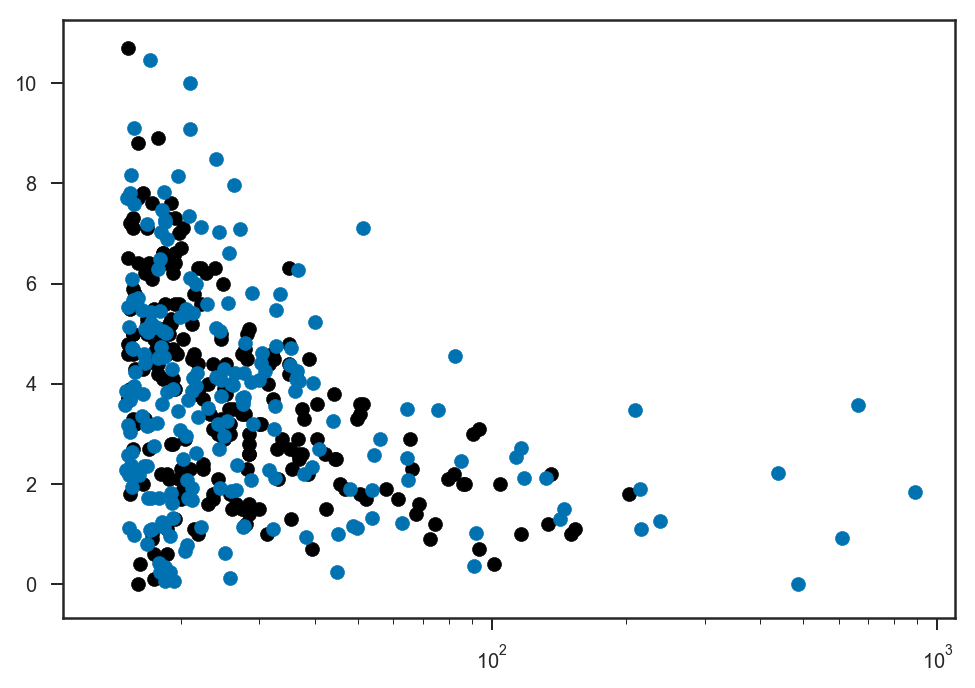

In [108]:
ms, dms, ts, dts = draw_systems(fit_std, chain_std)
scatter(stellar_parameters_all['Mini'][stellar_parameters_all['Mini']>MCut_std], stellar_parameters_all['age'][stellar_parameters_all['Mini']>MCut_std], color='k')
scatter(ms, ts, color=sns.color_palette()[0])
xscale('log')

And here is a plot of the empirical $\diff{N}{M}$ for the actual data and the synthetic observations from the "standard" model:

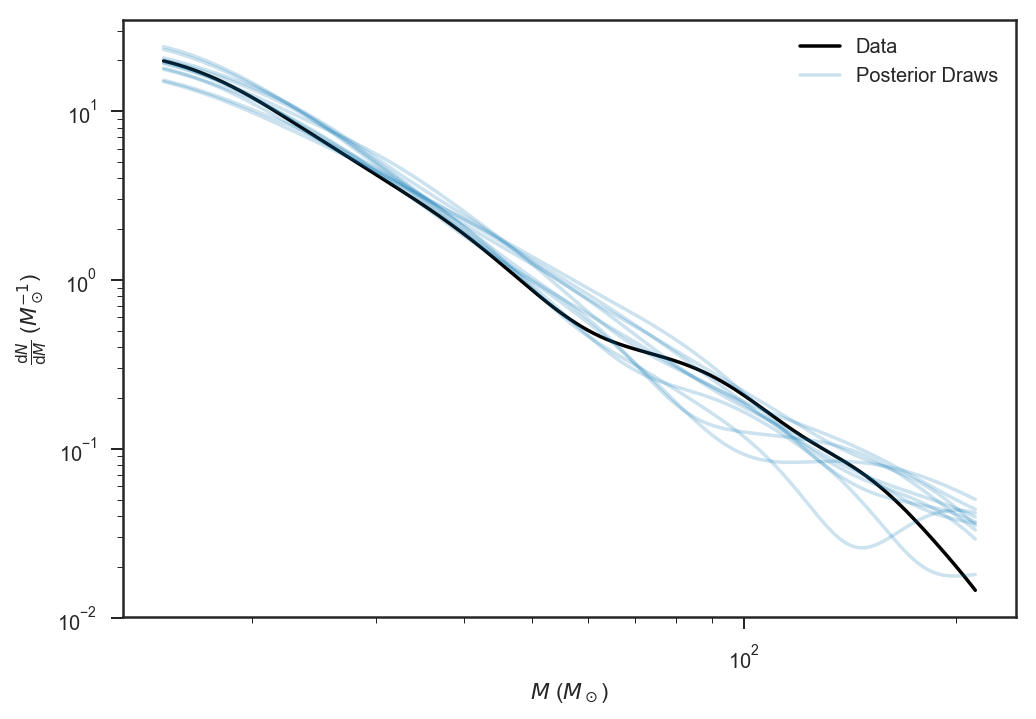

In [111]:
ms = logspace(log10(MCut_std), log10(np.max(stellar_parameters_expanded['Mini'])+10), 1000)
plot(ms, empirical_dNdM(stellar_parameters_expanded['Mini'][stellar_parameters_expanded['Mini']>MCut_std])(ms), color='k', label='Data')

for i in range(10):
    ms_draw, _, _, _ = draw_systems(fit_std, chain_std)
    if i == 0:
        l = 'Posterior Draws'
    else:
        l = None
    plot(ms, empirical_dNdM(ms_draw)(ms), color=sns.color_palette()[0], alpha=0.2, label=l)
yscale('log')
xscale('log')
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
legend(loc='best')

savefig('dNdM-ppc-lightning.pdf')

Or, here is an alternate version of this figure:

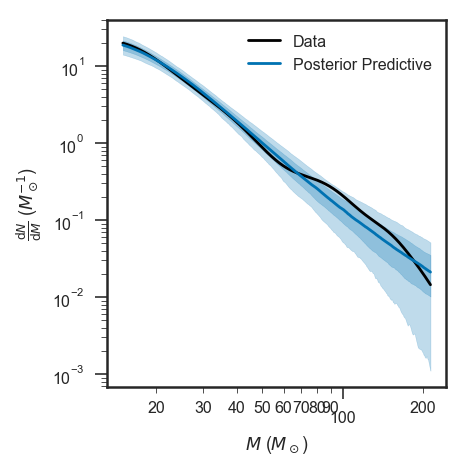

In [113]:
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    return '%1i' % (x)

with sns.plotting_context('paper', rc=pubrc):
    ax = subplot(111)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    formatter = FuncFormatter(log_10_product)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_minor_formatter(formatter)
    
    #xlocator = MultipleLocator(40)
    #ax.xaxis.set_minor_locator(NullLocator())
    
    ms = logspace(log10(MCut_std), log10(np.max(stellar_parameters_expanded['Mini'])+10), 1000)
    ax.plot(ms, empirical_dNdM(stellar_parameters_expanded['Mini'][stellar_parameters_expanded['Mini']>MCut_std])(ms), color='k', label='Data')

    edNdMs = []
    for i in range(1000):
        ms_draw, _, _, _ = draw_systems(fit_std, chain_std)
        edNdMs.append(empirical_dNdM(ms_draw)(ms))
    edNdMs = array(edNdMs)

    ax.plot(ms, median(edNdMs, axis=0), color=sns.color_palette()[0], label='Posterior Predictive')
    ax.fill_between(ms, percentile(edNdMs, 84, axis=0), percentile(edNdMs, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
    ax.fill_between(ms, percentile(edNdMs, 97.5, axis=0), percentile(edNdMs, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)

    ax.set_xlabel(r'$M$ ($M_\odot$)')
    ax.set_ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} M}$ ($M_\odot^{-1}$)')
    ax.legend(loc='best')
    
    tight_layout()
    
    savefig('dNdM-ppc-band.pdf')

And the same for age:

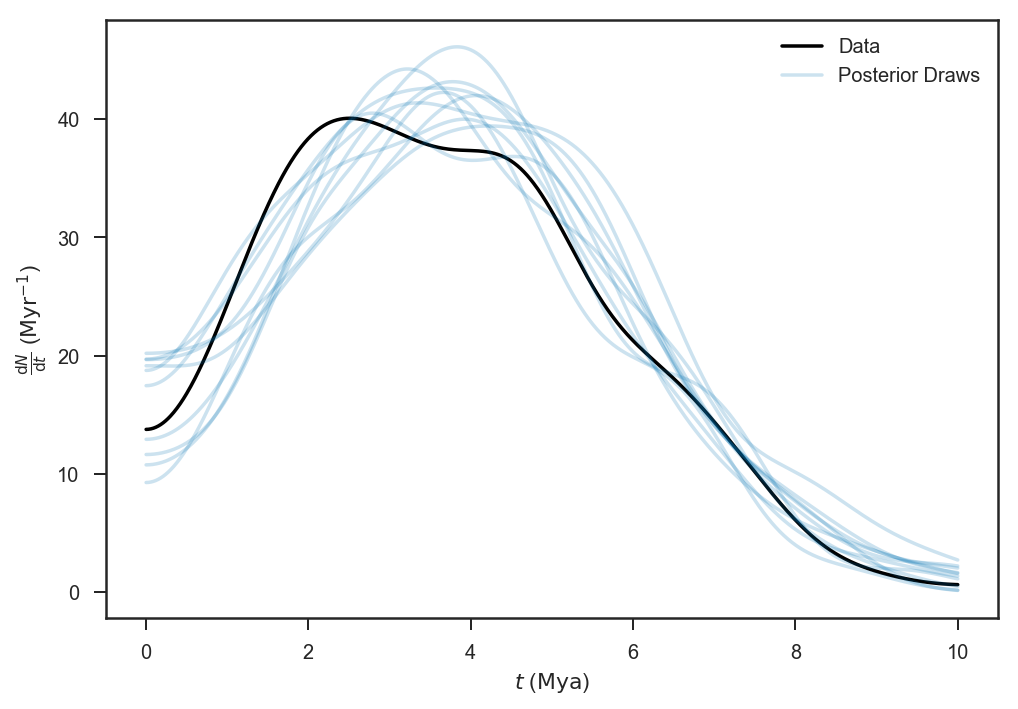

In [114]:
ts = linspace(0, 10, 1000)
plot(ts, empirical_dNdt(stellar_parameters_expanded['age'][stellar_parameters_expanded['Mini']>MCut_std])(ts), color='k', label='Data')

for i in range(10):
    _, _, ts_draw, _ = draw_systems(fit_std, chain_std)
    if i == 0:
        l = 'Posterior Draws'
    else:
        l = None
    plot(ts, empirical_dNdt(ts_draw)(ts), color=sns.color_palette()[0], alpha=0.2, label=l)
xlabel(r'$t$ ($\mathrm{Mya}$)')
ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')
legend(loc='best')

savefig('dNdt-ppc-lightning.pdf')

And, as before, an alternate version of the figure:

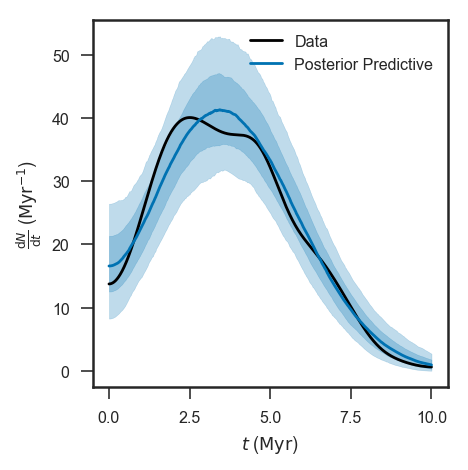

In [115]:
with sns.plotting_context('paper', rc=pubrc):

    ts = linspace(0, 10, 1000)
    plot(ts, empirical_dNdt(stellar_parameters_expanded['age'][stellar_parameters_expanded['Mini']>MCut_std])(ts), color='k', label='Data')

    edNdts = []
    for i in range(1000):
        _, _, ts_draw, _ = draw_systems(fit_std, chain_std)
        edNdts.append(empirical_dNdt(ts_draw)(ts))
    edNdts = array(edNdts)

    plot(ts, median(edNdts, axis=0), color=sns.color_palette()[0], label='Posterior Predictive')
    fill_between(ts, percentile(edNdts, 84, axis=0), percentile(edNdts, 16, axis=0), color=sns.color_palette()[0], alpha=0.25)
    fill_between(ts, percentile(edNdts, 97.5, axis=0), percentile(edNdts, 2.5, axis=0), color=sns.color_palette()[0], alpha=0.25)
    xlabel(r'$t$ ($\mathrm{Myr}$)')
    ylabel(r'$\frac{\mathrm{d} N}{\mathrm{d} t}$ ($\mathrm{Myr}^{-1}$)')
    legend(loc='best')
    
    tight_layout()

    savefig('dNdt-ppc-band.pdf')

### Stars Heavier Than $30 \, \MSun$ and $60\, \MSun$

Fabian suggested checking that the correct number of stars heavier than $30 \, \MSun$ and $60 \, \MSun$ are produced.  Here we perform that check for all our models.  Note that the appropriate comparison for the first three models (fit to the "expanded" data set) is with the number of stars observed in the "expanded" data set; for the fourth model, the appropriate data comparison is with the "safe" data set.  This is indicated below by the black and pink vertical lines, respectively.  You can see that all models regularly produce data that has similar numbers of stars above 30 and 60 solar masses to the observed data sets.

In [116]:
mnames = ['S+ l.t., 15 MSun, exp.',
          'our l.t., 15 MSun, exp.',
          'our l.t., 20 MSun, exp.',
          'our l.t., 20 MSun, safe']
fits = [fit_std, fit_our_lt, fit_our_lt_20cut, fit_our_lt_20cut_safe]
chains = [chain_std, chain_our_lt, chain_our_lt_20cut, chain_our_lt_20cut_safe]

n30 = {}
n60 = {}

for n, f, c in zip(mnames, fits, chains):
    n3 = []
    n6 = []
    for i in range(1000):
        m, dm, t, dt = draw_systems(f, c)
        n3.append(count_nonzero(m > 30))
        n6.append(count_nonzero(m > 60))
    n30[n] = array(n3)
    n60[n] = array(n6)

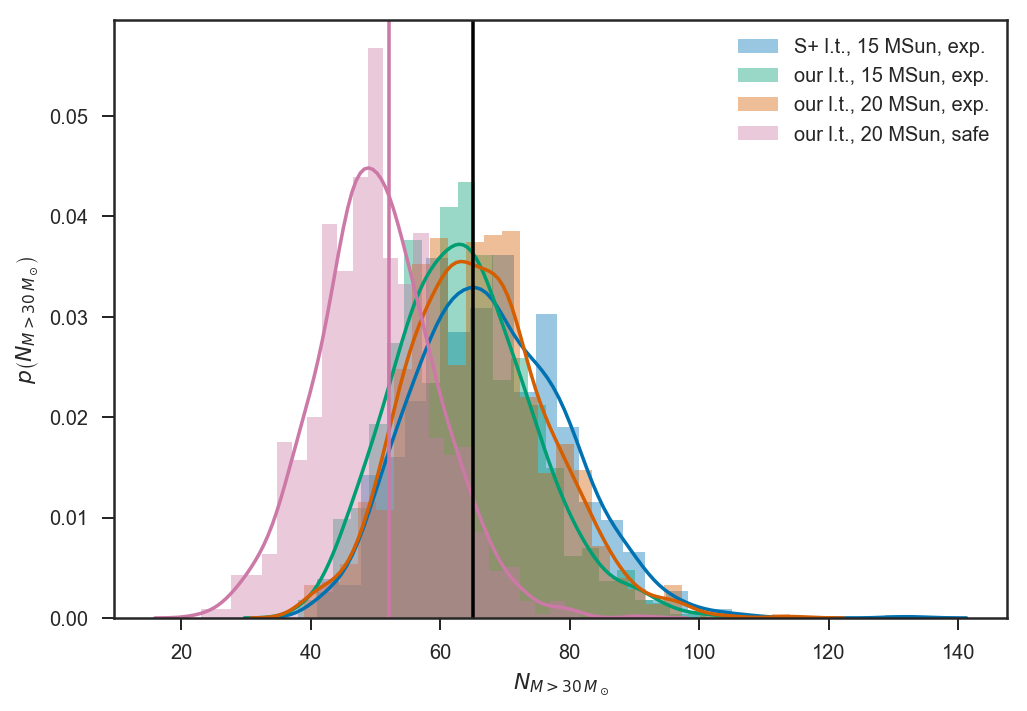

In [119]:
for n in mnames:
    sns.distplot(n30[n], label=n)
axvline(count_nonzero(stellar_parameters_expanded['Mini'] > 30), color='k')
axvline(count_nonzero(stellar_parameters_safe['Mini'] > 30), color=sns.color_palette()[len(mnames)-1])
legend(loc='best')
xlabel(r'$N_{M > 30 \, M_\odot}$')
ylabel(r'$p\left(N_{M > 30 \, M_\odot}\right)$')

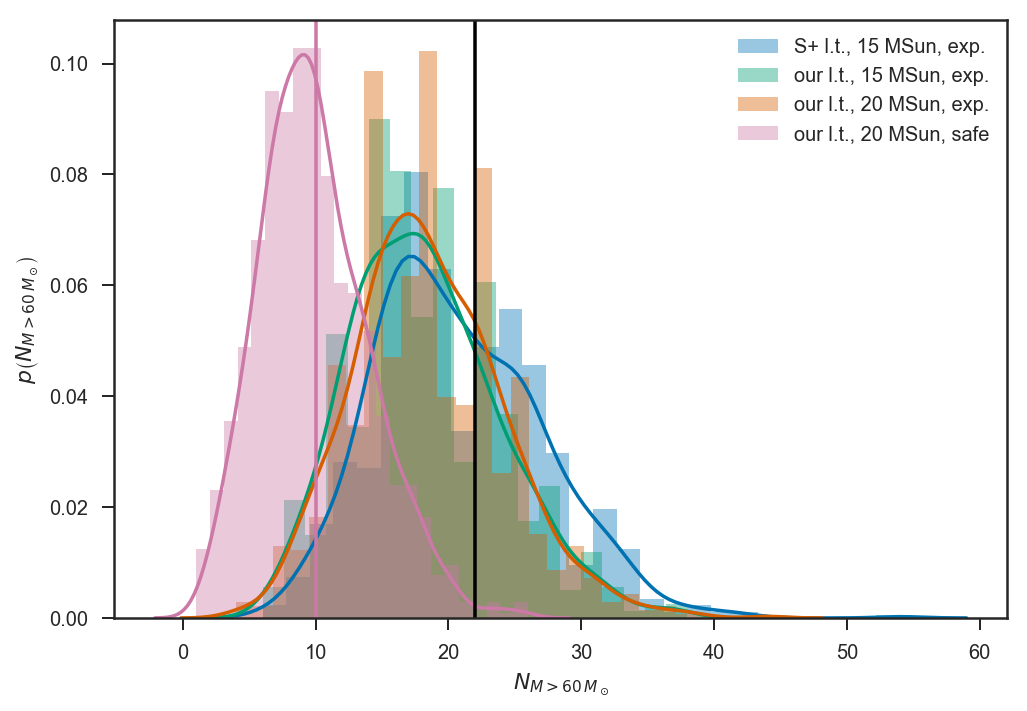

In [120]:
for n in mnames:
    sns.distplot(n60[n], label=n)
axvline(count_nonzero(stellar_parameters_expanded['Mini'] > 60), color='k')
axvline(count_nonzero(stellar_parameters_safe['Mini'] > 60), color=sns.color_palette()[len(mnames)-1])
legend(loc='best')
xlabel(r'$N_{M > 60 \, M_\odot}$')
ylabel(r'$p\left(N_{M > 60 \, M_\odot}\right)$')